# Image Segmentation Task 1
#### Welcome to the first task of Image Segmentation. Image segmentation is the process of partitioning the image into a set of pixels representing an object. In this task, you will be introduced to the problem of image segmentation and programming pipeline involved in image segmentation.

In [ ]:
# We used google drive, so, we had to mount the directory first
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

For the purpose of this task we will be using PASCAL VOC datset. The dataset contains a total of 2913 images with segmentation annotations. Code in the cell below will download the code and extract the dataset.

In [ ]:
!wget http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar
!tar -xvf VOCtrainval_11-May-2012.tar

In [ ]:
!pip install scipy==1.1.0

### 1.1 Loading the dataset

In [2]:
import os
from os.path import join as pjoin
import collections
import json
import torch
import imageio
import numpy as np
import scipy.misc as m
import scipy.io as io
import matplotlib.pyplot as plt
import glob

from PIL import Image
from tqdm import tqdm
from torch.utils import data
from torchvision import transforms


class pascalVOCDataset(data.Dataset):
    """Data loader for the Pascal VOC semantic segmentation dataset.

    Annotations from both the original VOC data (which consist of RGB images
    in which colours map to specific classes) and the SBD (Berkely) dataset
    (where annotations are stored as .mat files) are converted into a common
    `label_mask` format.  Under this format, each mask is an (M,N) array of
    integer values from 0 to 21, where 0 represents the background class.

    The label masks are stored in a new folder, called `pre_encoded`, which
    is added as a subdirectory of the `SegmentationClass` folder in the
    original Pascal VOC data layout.

    A total of five data splits are provided for working with the VOC data:
        train: The original VOC 2012 training data - 1464 images
        val: The original VOC 2012 validation data - 1449 images
        trainval: The combination of `train` and `val` - 2913 images
        train_aug: The unique images present in both the train split and
                   training images from SBD: - 8829 images (the unique members
                   of the result of combining lists of length 1464 and 8498)
        train_aug_val: The original VOC 2012 validation data minus the images
                   present in `train_aug` (This is done with the same logic as
                   the validation set used in FCN PAMI paper, but with VOC 2012
                   rather than VOC 2011) - 904 images
    """

    def __init__(
        self,
        root,
        sbd_path=None,
        split="train_aug",
        is_transform=False,
        img_size=512,
        augmentations=None,
        img_norm=True,
        test_mode=False,
    ):
        self.root = root
        self.sbd_path = sbd_path
        self.split = split
        self.is_transform = is_transform
        self.augmentations = augmentations
        self.img_norm = img_norm
        self.test_mode = test_mode
        self.n_classes = 21
        self.mean = np.array([104.00699, 116.66877, 122.67892])
        self.files = collections.defaultdict(list)
        self.img_size = img_size if isinstance(img_size, tuple) else (img_size, img_size)

        if not self.test_mode:
            for split in ["train", "val", "trainval"]:
                path = pjoin(self.root, "ImageSets/Segmentation", split + 
                             ".txt")
                file_list = tuple(open(path, "r"))
                file_list = [id_.rstrip() for id_ in file_list]
                self.files[split] = file_list
            self.setup_annotations()

        self.tf = transforms.Compose(
            [
                # add more trasnformations as you see fit
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], 
                                     [0.229, 0.224, 0.225]),
            ]
        )

    def __len__(self):
        return len(self.files[self.split])

    def __getitem__(self, index):
        im_name = self.files[self.split][index]
        im_path = pjoin(self.root, "JPEGImages", im_name + ".jpg")
        lbl_path = pjoin(self.root, "SegmentationClass/pre_encoded", 
                         im_name + ".png")
        im = Image.open(im_path)
        lbl = Image.open(lbl_path)
        if self.augmentations is not None:
            im, lbl = self.augmentations(im, lbl)
        if self.is_transform:
            im, lbl = self.transform(im, lbl)
        return im, torch.clamp(lbl, max=20)

    def transform(self, img, lbl):
        if self.img_size == ("same", "same"):
            pass
        else:
            # uint8 with RGB mode
            img = img.resize((self.img_size[0], self.img_size[1]))
            lbl = lbl.resize((self.img_size[0], self.img_size[1]))
        img = self.tf(img)
        lbl = torch.from_numpy(np.array(lbl)).long()
        lbl[lbl == 255] = 0
        return img, lbl

    def get_pascal_labels(self):
        """Load the mapping that associates pascal classes with label colors

        Returns:
            np.ndarray with dimensions (21, 3)
        """
        return np.asarray(
            [
                [0, 0, 0],
                [128, 0, 0],
                [0, 128, 0],
                [128, 128, 0],
                [0, 0, 128],
                [128, 0, 128],
                [0, 128, 128],
                [128, 128, 128],
                [64, 0, 0],
                [192, 0, 0],
                [64, 128, 0],
                [192, 128, 0],
                [64, 0, 128],
                [192, 0, 128],
                [64, 128, 128],
                [192, 128, 128],
                [0, 64, 0],
                [128, 64, 0],
                [0, 192, 0],
                [128, 192, 0],
                [0, 64, 128],
            ]
        )

    def encode_segmap(self, mask):
        """Encode segmentation label images as pascal classes

        Args:
            mask (np.ndarray): raw segmentation label image of dimension
              (M, N, 3), in which the Pascal classes are encoded as colours.

        Returns:
            (np.ndarray): class map with dimensions (M,N), where the value at
            a given location is the integer denoting the class index.
        """
        mask = mask.astype(int)
        label_mask = np.zeros((mask.shape[0], mask.shape[1]), dtype=np.int16)
        for ii, label in enumerate(self.get_pascal_labels()):
            label_mask[np.where(np.all(mask == label, axis=-1))[:2]] = ii
        label_mask = label_mask.astype(int)
        # print(np.unique(label_mask))
        return label_mask

    def decode_segmap(self, label_mask, plot=False):
        """Decode segmentation class labels into a color image

        Args:
            label_mask (np.ndarray): an (M,N) array of integer values denoting
              the class label at each spatial location.
            plot (bool, optional): whether to show the resulting color image
              in a figure.

        Returns:
            (np.ndarray, optional): the resulting decoded color image.
        """
        label_colours = self.get_pascal_labels()
        r = label_mask.copy()
        g = label_mask.copy()
        b = label_mask.copy()
        for ll in range(0, self.n_classes):
            r[label_mask == ll] = label_colours[ll, 0]
            g[label_mask == ll] = label_colours[ll, 1]
            b[label_mask == ll] = label_colours[ll, 2]
        rgb = np.zeros((label_mask.shape[0], label_mask.shape[1], 3))
        rgb[:, :, 0] = r / 255.0
        rgb[:, :, 1] = g / 255.0
        rgb[:, :, 2] = b / 255.0
        if plot:
            plt.imshow(rgb)
            plt.show()
        else:
            return rgb

    def setup_annotations(self):
        """Sets up Berkley annotations by adding image indices to the
        `train_aug` split and pre-encode all segmentation labels into the
        common label_mask format (if this has not already been done). This
        function also defines the `train_aug` and `train_aug_val` data splits
        according to the description in the class docstring
        """
        sbd_path = self.sbd_path
        target_path = pjoin(self.root, "SegmentationClass/pre_encoded")
        if not os.path.exists(target_path):
            os.makedirs(target_path)
        train_aug = self.files["train"]

        # keep unique elements (stable)
        train_aug = [train_aug[i] for i in 
                     sorted(np.unique(train_aug, return_index=True)[1])]
        self.files["train_aug"] = train_aug
        set_diff = set(self.files["val"]) - set(train_aug)  # remove overlap
        self.files["train_aug_val"] = list(set_diff)

        pre_encoded = glob.glob(pjoin(target_path, "*.png"))
        expected = np.unique(self.files["train_aug"] + self.files["val"]).size

        if len(pre_encoded) != expected:
            print("Pre-encoding segmentation masks...")

            for ii in tqdm(self.files["trainval"]):
                fname = ii + ".png"
                lbl_path = pjoin(self.root, "SegmentationClass", fname)
                lbl = self.encode_segmap(m.imread(lbl_path))
                lbl = m.toimage(lbl, high=lbl.max(), low=lbl.min())
                m.imsave(pjoin(target_path, fname), lbl)

        assert expected == 2913, "unexpected dataset sizes"

### 1.2 Define the model architecture(2.0 point)
In this section you have the freedom to decide your own model. Keep in mind though, to perform image segmentation, you need to implement an architecture that does pixel level classification i.e. for each pixel in the image you need to predict the probability of it belonging to one of the 21 categories.

In [5]:
import torch.nn as nn

class Segnet(nn.Module):  
    def __init__(self, num_classes=21, weights=None):
        """
        UNet of depth 4
        :param num_classes: number of output classes to distinguish
        :param weights: file with precomputed weights
        """
        super(Segnet, self).__init__()
        
        self.num_classes = num_classes

        # feature extraction
        self.d_conv11 = nn.Conv2d(3, 16, 3, padding=1)
        self.b_norm11 = nn.BatchNorm2d(16)
        self.d_conv12 = nn.Conv2d(16, 16, 3, padding=1)
        self.b_norm12 = nn.BatchNorm2d(16)
        
        self.d_conv21 = nn.Conv2d(16, 32, 3, padding=1)
        self.b_norm21 = nn.BatchNorm2d(32)
        self.d_conv22 = nn.Conv2d(32, 32, 3, padding=1)
        self.b_norm22 = nn.BatchNorm2d(32)
        
        self.d_conv31 = nn.Conv2d(32, 64, 3, padding=1)
        self.b_norm31 = nn.BatchNorm2d(64)
        self.d_conv32 = nn.Conv2d(64, 64, 3, padding=1)
        self.b_norm32 = nn.BatchNorm2d(64)
        
        self.d_conv41 = nn.Conv2d(64, 128, 3, padding=1)
        self.b_norm41 = nn.BatchNorm2d(128)
        self.d_conv42 = nn.Conv2d(128, 128, 3, padding=1)
        self.b_norm42 = nn.BatchNorm2d(128)
        
        # feature mapping onto the original image size
        self.b_conv51 = nn.Conv2d(128, 256, 3, padding=1)
        self.b_conv52 = nn.Conv2d(256, 256, 3, padding=1)
        
        self.u_conv41 = nn.Conv2d(256, 128, 3, padding=1)
        self.u_conv42 = nn.Conv2d(256, 128, 3, padding=1)
        
        self.u_conv31 = nn.Conv2d(128, 64, 3, padding=1)
        self.u_conv32 = nn.Conv2d(128, 64, 3, padding=1)
        
        self.u_conv21 = nn.Conv2d(64, 32, 3, padding=1)
        self.u_conv22 = nn.Conv2d(64, 32, 3, padding=1)
        
        self.u_conv11 = nn.Conv2d(32, 16, 3, padding=1)
        self.u_conv12 = nn.Conv2d(32, 16, 3, padding=1)
        
        self.o_conv01 = nn.Conv2d(16, 16, 3, padding=1)
        self.o_conv02 = nn.Conv2d(16, self.num_classes, 3, padding=1)
        
        # if provided, load precomputed weights
        if weights is not None:
            self.load(weights)
  
    def forward(self, x):
        """
        Forward a tensor through the network. The tensor should have the format:
        batch_size x num_channels x width x height
        :param x: input tensor to the network, should be 4-dimensional
        :return: prediction of the network as a 4-dimensional tensor
        """
        # The dimensionality comments are given as width x height x channels
        # x = 512x512x3
        x = self.d_conv11(x)
        x = nn.ReLU()(x)
        x = self.b_norm11(x)

        # x = 512x512x16
        x1 = self.d_conv12(x)
        x = nn.MaxPool2d(2)(x1)
        x = nn.ReLU()(x)
        x = self.b_norm12(x)

        # x = 256x256x16
        x = self.d_conv21(x)
        x = nn.ReLU()(x)
        x = self.b_norm21(x)

        # x = 256x256x32
        x2 = self.d_conv22(x)
        x = nn.MaxPool2d(2)(x2)
        x = nn.ReLU()(x)
        x = self.b_norm22(x)

        # x = 128x128x32
        x = self.d_conv31(x)
        x = nn.ReLU()(x)
        x = self.b_norm31(x)

        # x = 128x128x64
        x3 = self.d_conv32(x)
        x = nn.MaxPool2d(2)(x3)
        x = nn.ReLU()(x)
        x = self.b_norm32(x)

        # x = 64x64x64
        x = self.d_conv41(x)
        x = nn.ReLU()(x)
        x = self.b_norm41(x)

        # x = 64x64x128
        x4 = self.d_conv42(x)
        x = nn.MaxPool2d(2)(x4)
        x = nn.ReLU()(x)
        x = self.b_norm42(x)

        # x = 32x32x128
        x = self.b_conv51(x)
        x = nn.ReLU()(x)
        
        # x = 32x32x256
        x = self.b_conv52(x)
        x = nn.ReLU()(x)
        
        # x = 32x32x256
        x = nn.Upsample(scale_factor=2)(x)
        # x = 64x64x256
        x = self.u_conv41(x)
        x = nn.ReLU()(x)
        x = torch.cat((x, x4), dim=1)
        x = self.u_conv41(x)
        x = nn.ReLU()(x)
        
        # x = 64x64x128
        x = nn.Upsample(scale_factor=2)(x)
        # x = 128x128x128
        x = self.u_conv31(x)
        x = nn.ReLU()(x)
        x = torch.cat((x, x3), dim=1)
        x = self.u_conv32(x)
        x = nn.ReLU()(x)
        
        # x = 128x128x64
        x = nn.Upsample(scale_factor=2)(x)
        # x = 256x256x64
        x = self.u_conv21(x)
        x = nn.ReLU()(x)
        x = torch.cat((x, x2), dim=1)
        x = self.u_conv22(x)
        x = nn.ReLU()(x)
        
        # x = 256x256x32
        x = nn.Upsample(scale_factor=2)(x)
        # x = 512x512x32
        x = self.u_conv11(x)
        x = nn.ReLU()(x)
        x = torch.cat((x, x1), dim=1)
        x = self.u_conv12(x)
        x = nn.ReLU()(x)
        
        x = self.o_conv01(x)
        x = nn.ReLU()(x)
        x = self.o_conv02(x)
        
        return x
    
    def classify(self, x):
        """
        Use the network for classification by applying pixelwise argmax to the output of forward
        :param x: input-tensor to classify, should be 4-dimensional
        :return: classifications for each pixel, given by their class index
        """
        return self.forward(x).argmax(dim=1)

    def save(self, file_name):
        """
        Save the state of the network into the given file
        :param file_name: path to the file to store the network weights in
        """
        torch.save(self.state_dict(), file_name)

    def load(self, file_name):
        """
        Load the state of the network from the given file
        :param file_name: path to the file that stored the weights
        """
        self.load_state_dict(torch.load(file_name))

In [6]:
# initialize the divice to run on
if torch.cuda.is_available():
    dev = "cuda:0"
    print("Using GPU")
else:
    dev = "cpu"
    print("Using CPU")
device = torch.device(dev)

# Creating an instance of the model defined above
model = Segnet().to(device)
print("Model has", 
      sum(p.numel() for p in model.parameters() if p.requires_grad), 
      "parameters")

Using GPU
Model has 1968933 parameters


### 1.3 Hyperparameters(0.5 points)
Define all the hyperparameters(not restricted to the three given below) that you find useful here.

In [8]:
# modify project_root_dir according to your device
project_root_dir = "/content/drive/My Drive/Project"
local_path = pjoin(project_root_dir, 'data/VOCtrainval_11-May-2012/VOCdevkit/VOC2012/')
weights_path = pjoin(project_root_dir, "weights")
batch_size = 16
start_epoch = 0
end_epoch = 250
learning_rate = 0.001
weighted_loss = False

'''
the weights for the CE-Loss are computed by counting the occurrences in the
solution-masks of the train_aug dataset given above. After summing this up into
a 21-dimensional vector we compute the actual weights as the quotient of the 
total number of pixels in all images of the dataset and the number of 
occurrences of a single class. So, the classes are weighted antiproportional to
their frequency.
Because this feature in not used in other implementation of this or similar
tasks, we left it out.
'''
weights = torch.tensor([1.3430940387071182, 116.4971625395112, 
                        272.7166120445353, 112.22833380853163, 
                        155.90548632359608, 158.07671880850202, 
                        57.761409034756284, 71.85013757683176, 
                        38.8753618302696, 91.72158977250213, 
                        120.50800034540416, 78.64502108348, 
                        62.279856790615504, 111.59948983597633, 
                        92.09545916487988, 22.616427610560393, 
                        148.97187660969738, 118.59421204814363, 
                        73.02657358784822, 66.65363207665139, 
                        114.32628401491507]).to(device)


### 1.4 Dataset and Dataloader(0.5 points)
Create the dataset using pascalVOCDataset class defined above. Use local_path defined in the cell above as root. 

In [9]:
# dataset variable
# this step takes once around 15 minutes to create the masks
dst = pascalVOCDataset(root=local_path, is_transform=True)

# dataloader variable
trainloader = data.DataLoader(dst, batch_size=batch_size, shuffle=True)

### 1.5 Loss fuction and Optimizer(1.0 point)
Define below with the loss function you think would be most suitable for segmentation task. You are free to choose any optimizer to train the network.

In [10]:
# loss function
# as this is a classification task, the CrossEntropyLoss an appropriate choice
if weighted_loss:
    loss_f = nn.CrossEntropyLoss(weight=weights)
else:
    loss_f = nn.CrossEntropyLoss()

# optimizer variable
opt = torch.optim.Adam(model.parameters(), lr=learning_rate)

### 1.6 Training the model(3.0 points)
Your task here is to complete the code below to perform a training loop and save the model weights after each epoch of training.

In [ ]:
# some general statistics
episode_losses = []
episode_accuracies = []

for e in range(start_epoch, end_epoch):
    
    # some episode statistics
    episode_loss = 0
    episode_accuracy = 0
    
    for i, d in enumerate(trainloader):
        
        # forwarding the data through the network and compute the loss
        output = model.forward(d[0].to(device))
        loss = loss_f(output, d[1].to(device))
        
        # backpropagation
        opt.zero_grad()
        loss.backward()
        opt.step()
        
        # do some statistics
        loss = loss.item()
        episode_loss += loss

        accuracy = torch.sum(output.argmax(dim=1).squeeze() == d[1].to(device)).item() / (512*512*batch_size)
        episode_accuracy += accuracy

        print("\rEpisode", e + 1, "/", end_epoch, "- Batch", i + 1, "/", 
              len(dst) // batch_size, "\tLoss:", loss, "\tAcc:", accuracy, end="")
    
    '''
    update the general statistics (the trainingset has a total of 1464 images)
    
    Dividing by i is not 100% correct, because the last batch might be smaller
    but for evaluation issues, this can be ignored, because the general trend is
    shown
    '''
    episode_losses.append(episode_loss / i)
    episode_accuracies.append(episode_accuracy / i)
    print("\rEpisode", e + 1, "/", end_epoch, "- Completed \tLoss:", 
          episode_losses[-1], "\tAcc:", episode_accuracies[-1])

    # save the models weights
    model.save(pjoin(weights_path, F"network_epoch0{e}.pth"))


In [15]:
# these are the data we've got from training. In order to no retrain the net every time, we inserted them here.
episode_losses = [1.6362308794325524, 1.3070307760448245, 1.2929355999925634, 1.279103154009515, 1.2673020592102637, 1.2521888797099774, 1.2223723439069896, 1.2211400932008094, 1.200173815528115, 1.1951436210464645, 1.1930503026469723, 1.180759337577191, 1.171391432756906, 1.1712533713697078, 1.1649841207724352, 1.1706791539768597, 1.157470695920043, 1.1475963441880195, 1.1402156156497998, 1.147625995861305, 1.1439611957623408, 1.1233760635931413, 1.1253557722647112, 1.1158855308543194, 1.105228813794943, 1.098717899767907, 1.1061324942242967, 1.0924514970936618, 1.0922302387572906, 1.0915783224525033, 1.0824545648071793, 1.078774435179574, 1.067918979204618, 1.0698945640207647, 1.0643201883022602, 1.0515047036684477, 1.056991417984386, 1.052365936420776, 1.0443707475295434, 1.0488923205124152, 1.0270570667235406, 1.0269373648769253, 1.027617368069324, 1.0218418535295424, 1.007022540647905, 0.9937355813089308, 0.9953128977136297, 0.991768404022678, 0.9882102137083536, 0.9751647697700249, 0.9746461432058733, 0.9658609681077056, 0.9502522716155419, 0.9570618108078673, 0.935844824209318, 0.9422272103173392, 0.9374249204174503, 0.9254239732092553, 0.9162528586911631, 0.9139602328394796, 0.9102122292413817, 0.8915317687359485, 0.8896636766391796, 0.8899653743911575, 0.870321531872173, 0.8587247539352585, 0.8566107533790253, 0.8523180465121846, 0.8354719444945619, 0.8476205330628616, 0.819610032078984, 0.8089253535637488, 0.7962140761888944, 0.799044301876655, 0.7772897809416384, 0.7685360564635351, 0.7738057663152506, 0.7503594539977692, 0.730605885877714, 0.7238108970961727, 0.741964768577408, 0.7140192176614489, 0.7221095247583075, 0.6986997120982998, 0.6807184988980765, 0.6821192873048258, 0.6675746126489325, 0.6656772736664657, 0.6508250341310606, 0.6442975441178123, 0.6418552998003069, 0.636208842088888, 0.6107117166885963, 0.5897939637467101, 0.5965610804793599, 0.5929018642221179, 0.5929820170769324, 0.5636957025789953, 0.5620653717727452, 0.5552237986863314, 0.5756766946761163, 0.5416357608941885, 0.5528824136152373, 0.5338007152735532, 0.5185909382589571, 0.5092799067497253, 0.5110876052589207, 0.49733418553740116, 0.5019898332737305, 0.4908564031779111, 0.48614999848407703, 0.48105195754176966, 0.4649803887356769, 0.4929288953215211, 0.4685438668334877, 0.5178355466533493, 0.43998569561229955, 0.42929312881532605, 0.42362724932340473, 0.4229190786788752, 0.44334747732340635, 0.4447964713141158, 0.40656030161695167, 0.42003690803443994, 0.4006892688326783, 0.38458884613854544, 0.3707589854250897, 0.39104115062362543, 0.4377360524057032, 0.3843490034341812, 0.3781577820306296, 0.3866197175377018, 0.3681833090690466, 0.3463565707206726, 0.33799346479085773, 0.3345930889085099, 0.3517697119450831, 0.35795725063308254, 0.32367063927781453, 0.3399465873346224, 0.349796073449837, 0.32515506069738787, 0.3251780970738484, 0.308012686751701, 0.33905588761790767, 0.3310818677092647, 0.3000752038353092, 0.30871780806190363, 0.3065129688807896, 0.305070582981948, 0.30086760026413006, 0.3417475097454511, 0.3124994755118758, 0.28855543575444065, 0.2689635560407743, 0.27935623975245505, 0.3009027340909937, 0.2995454708298484, 0.29345428992758743, 0.2701461162868437, 0.2767804243734905, 0.29480713786004664, 0.27807292817058143, 0.27037526175871, 0.2646119976109201, 0.2486462455529433, 0.2841558500633135, 0.2527101220010401, 0.26469364320183847, 0.2769828961118237, 0.24007019449721326, 0.2495462471967215, 0.2596067090283383, 0.2634560362650798, 0.23398439324164128, 0.2260162612566581, 0.24666523253852193, 0.23928123188542796, 0.2691880043718841, 0.2599786565853999, 0.21890578951154435, 0.23048767922343788, 0.22985122672149114, 0.2281365739283981, 0.20578651711508467, 0.21271314316398496, 0.20847991510079458, 0.20277060715706793, 0.23384780772439726, 0.21220178541901347, 0.3521580065672214, 0.2231746297943723, 0.23170548914880543, 0.19387991579024347, 0.1896861696636284, 0.17376855097629212, 0.18885119554105695, 0.19314736962973417, 0.20134490458192406, 0.18697470893244167, 0.22033173828334598, 0.21161661321645256, 0.19247123075055553, 0.17768528689067442, 0.17638443115648333, 0.18051817071634335, 0.22938952554058242, 0.260078245139384, 0.235924434367117, 0.1896257718185802, 0.18300622316834692, 0.17348339883508263, 0.17178611490097676, 0.18936880203066292, 0.17961149220610714, 0.22995921347167467, 0.17768871694148242, 0.1530600912295855, 0.20014421690951337, 0.17196549491567925, 0.1785363448517663, 0.1753217475591125, 0.1902938479414353, 0.17968384528553094, 0.22011125087738037, 0.18233806860970928, 0.1865173137777454, 0.15548081876157405, 0.16277009396107642, 0.18196581025699993, 0.1573704243688793, 0.1519547007404841, 0.16093688482766624, 0.15420522270621834, 0.1524116818557729, 0.18084177121028797, 0.1520392324079524, 0.1514278034587483, 0.16100333974911615, 0.2144469262643175, 0.20574767601031524, 0.18340489923299014, 0.17013557189768488, 0.13819828121871738, 0.13305770401116257, 0.13724450316730435, 0.18953065164796598, 0.22262909075061044, 0.1944860604765651, 0.16081881343008397]
episode_accuracies = [0.7245292506375156, 0.7486380692366715, 0.7486404246026344, 0.7486404350825718, 0.7485619482103285, 0.7485706544184423, 0.7484130964174376, 0.7485008134946718, 0.7492819382594182, 0.7489066726558811, 0.7488095655546083, 0.749698172558795, 0.7492952818398947, 0.7493500473735096, 0.7499892475840809, 0.7499516508081457, 0.7500248767517426, 0.7502325262342181, 0.7507452231187087, 0.7501975677825592, 0.7509080368083912, 0.7509922378665799, 0.750854743706001, 0.750601902112856, 0.7511051722935268, 0.7517932221129701, 0.7505739678393354, 0.7519052264454601, 0.7521164364867158, 0.7509802697779058, 0.7513986865242759, 0.7516382395566165, 0.7530412542950976, 0.7545766647045429, 0.7541622696342049, 0.7541537913647327, 0.7534148824083936, 0.753608525454343, 0.7552539699680203, 0.7547895803556337, 0.7563626347007332, 0.7550148754329472, 0.7562319472595885, 0.7564563358223045, 0.7576364265693413, 0.7594392535450695, 0.7581753835573302, 0.7587128366742816, 0.7579730343032669, 0.7605546778374976, 0.7603582366482242, 0.7612183094024658, 0.7620772241236089, 0.7614828675657839, 0.7643418154873691, 0.7643932562607986, 0.7647419552226643, 0.7673307932340182, 0.767726678114671, 0.7659541433984107, 0.7681010869833139, 0.7715288754347917, 0.770524928857992, 0.7708382501706972, 0.775176567035717, 0.7756561289776812, 0.7766103037111052, 0.7779025166899294, 0.7800064846709535, 0.7792261799613198, 0.7827391205253181, 0.786606796495207, 0.7885467665536063, 0.7858913311591516, 0.7910473346710205, 0.7935859161418873, 0.7930059013785896, 0.7945636628748296, 0.8003329968714452, 0.8016783929133153, 0.7982664579873556, 0.803402976675348, 0.8016750314733484, 0.8046334261422629, 0.8084760367215335, 0.8083988755613893, 0.8126191726097693, 0.8132047862796993, 0.8169013798891843, 0.8194396391019716, 0.8186362235100715, 0.8195302591219054, 0.8252351755624289, 0.8305150886158367, 0.8296686109605727, 0.8318690965463827, 0.8309461782266806, 0.8361370484907549, 0.8376602497729626, 0.8408176925156142, 0.8366285182617523, 0.8427808258559678, 0.8410635151705899, 0.8469300348680098, 0.8503668020059775, 0.8515935939746898, 0.8537754802913456, 0.8584006356668996, 0.8557003566196987, 0.8595947014106499, 0.8627302568037432, 0.8632690199128874, 0.8668695386949477, 0.8605048918462062, 0.8665018003065508, 0.8533237661634173, 0.875153620164473, 0.8779580147711785, 0.8798522844419374, 0.8803795536795815, 0.8740607906173874, 0.8738715648651123, 0.8862636508522453, 0.8823347825270432, 0.8867806314112066, 0.8929791371900957, 0.8953754875686143, 0.8900055911514785, 0.8789438939356542, 0.8924400151430906, 0.8922462227580311, 0.8925187011341472, 0.8966036550291292, 0.9036428116180084, 0.9046668744349218, 0.9062644020541684, 0.9025445482233069, 0.9015983592022906, 0.9094268253871373, 0.9059825729537796, 0.9039647736392178, 0.9114024350931357, 0.9104865278516497, 0.9149950834421011, 0.9065316876212319, 0.9082057790441828, 0.9184057502956181, 0.9158731816889165, 0.9167762903066782, 0.9168761745913998, 0.9176964524028065, 0.9064434255872454, 0.9157061367244511, 0.9214916674645393, 0.9273715412223732, 0.9244081790630634, 0.9188763178311862, 0.9204079371232253, 0.9222789570525453, 0.9280168748163915, 0.9265335889963003, 0.9224245312449696, 0.9262723398732615, 0.9279301664331457, 0.9307109130607857, 0.9352955503778143, 0.9252420100536976, 0.934536962718754, 0.9321093716464199, 0.9292431401682424, 0.9380443724957142, 0.9358334567520644, 0.9334908317733597, 0.9320535135793162, 0.9410735277029184, 0.9434956246679955, 0.9364276246710138, 0.9391473125625442, 0.930960149555416, 0.9346237025418125, 0.946401331450913, 0.9415527778667409, 0.9430634346637097, 0.9426579947000021, 0.949041662635384, 0.9471572414859311, 0.9487177382458697, 0.950177279147473, 0.9412379186232012, 0.949463739499941, 0.911124410210075, 0.944555177793398, 0.9415489317296626, 0.9526912773048485, 0.9543736321585519, 0.9587145847278636, 0.9541223573160695, 0.9533371794354785, 0.9505861539107102, 0.9553334555783115, 0.9459149103898269, 0.9478793353824825, 0.9533770267780011, 0.9581700340732113, 0.9583368615789728, 0.9573245467720451, 0.944343857712798, 0.9354400660965468, 0.942426364500444, 0.9550127354297009, 0.9572207613305731, 0.9600000695867853, 0.960323684818142, 0.9555529683500856, 0.958081609600193, 0.9424195813608693, 0.9583097028208303, 0.9660520081991678, 0.9517849801660894, 0.960649257177835, 0.9588409465747875, 0.9592826759422218, 0.9557474550310072, 0.9587408579312838, 0.9473536093156416, 0.9575197591886415, 0.9564661612877479, 0.9656561809581715, 0.9627373532934503, 0.9579911991790101, 0.9644502440651694, 0.9667247022901263, 0.964671294767778, 0.9656115940638951, 0.9669884954180036, 0.9581371087294358, 0.9665760365161267, 0.9667998591622153, 0.964574926502102, 0.949647028367598, 0.951730843428727, 0.9580968893491305, 0.9614349459553813, 0.9708049873729329, 0.9722513733329353, 0.971232105087448, 0.957038334437779, 0.9477248715830373, 0.9564520369519244, 0.9655327246739314]

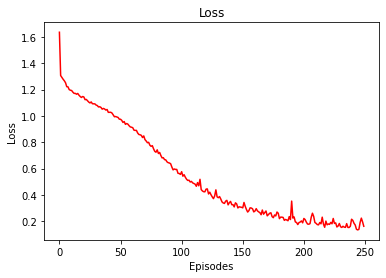

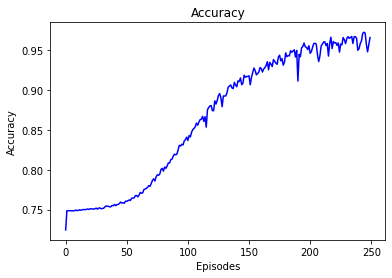

In [16]:
import matplotlib.pyplot as plt

plt.title("Loss")
plt.xlabel("Episodes")
plt.ylabel("Loss")
plt.plot(episode_losses, "r")
plt.savefig(pjoin(project_root_dir, "task1_losses.png"))
plt.show()

plt.title("Accuracy")
plt.xlabel("Episodes")
plt.ylabel("Accuracy")
plt.savefig(pjoin(project_root_dir, "task1_accurracies.png"))
plt.plot(episode_accuracies, "b")
plt.show()

In [19]:
# save lines!
f = open(pjoin(project_root_dir, "task1_losses.csv"), "w")
f.write(",".join([str(l) for l in episode_losses]) + "\n")
f.flush()
f.close()

f = open(pjoin(project_root_dir, "task1_accuracies.csv"), "w")
f.write(",".join([str(l) for l in episode_accuracies]) + "\n")
f.flush()
f.close()

### 1.7 Evaluate your model(1.5 points)
In this section you have to implement the evaluation metrics for your model. Calculate the values of F1-score, dice coefficient and AUC-ROC score on the data you used for training. You can use external packages like scikit-learn to compute above metrics.

In [28]:
from sklearn.metrics import roc_auc_score, f1_score, jaccard_score


def image_auc(ground_truth, prediction):
    """
    Compute the AUC of the input image and the ground truth
    :param ground_truth: true labels of each pixel
    :param prediction: predictions for each classes and pixel, i.e. the
    :return: AUC of the input image compared to the ground truth
    """
    # prediction should be the classification, not the argmaxed network-output
    prediction = prediction.view(21, 512 * 512).softmax(dim=0).transpose(0, 1).numpy()

    # this is done to ensure that every class occurs at least once in the true
    # labels. This is necessary, otherwise sklearn cannot compute the 
    # One-vs-all setting of the AUC. This will give not 100% correct results, 
    # but changing at most 21 of 262144 pixels (8*10^(-3)%) is not dramatic.
    for i in range(21):
        ground_truth[i] = i

    return roc_auc_score(ground_truth, prediction, average="weighted", multi_class="ovr", labels=list(range(21)))


def image_f1(ground_truth, prediction):
    """
    Compute the F1 score of the input image and the ground truth
    :param ground_truth: true labels for each pixel
    :param prediction: predicted classes for each pixel
    :return: f1 score of the input image compared to the ground truth
    """
    return f1_score(ground_truth, prediction, average='weighted')


def image_dice(ground_truth, prediction):
    """
    Compute the dice_coefficient based on the jaccard score as they are convertible using the formula provided on
    wikipedia: https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient#Difference_from_Jaccard
    :param ground_truth: true labels of each pixel
    :param prediction: predicted classes for each pixel
    :return: soerensen-dice-coefficient of the input image compared to the ground truth
    """
    jaccard = jaccard_score(ground_truth, prediction, average='weighted')
    return (2 * jaccard) / (1 + jaccard)


def eval_epoch(epoch, length, valloader, project_root_dir, batch_size):
    """
    Evaluate an epoch by computing the F1 score, the AUC and the Dice Coefficient
    :param epoch: number of epoch to evaluate
    :param length: number of samples in the dataset
    :param valloader: dataloader for the validation set
    :return: F1, AUC, and Dice scores for this episode
    """
    # initialize the model
    model = Segnet(weights=pjoin(weights_path, F"network_epoch{epoch}.pth")).to(device)

    f1, auc, dice, i = 0, 0, 0, 1

    # iterate over all samples in the dataset
    for i, d in enumerate(valloader):
        # print the progress
        print("\r", i, "/", length, end="")

        # as we only use forward and don't want to train the model no gradients need to be computed
        with torch.no_grad():
            # forward the image through the model
            prediction = model.forward(d[0].to(device)).cpu().squeeze()
            label_array = d[1].view(batch_size, 512 * 512).numpy()
            prediction_array = prediction.argmax(dim=1).squeeze().view(batch_size, 512 * 512).numpy()

            # for each image in the batch, compute the scores
            for b in range(batch_size):
                f1 += image_f1(label_array[b], prediction_array[b])
                auc += image_auc(label_array[b], prediction[b])
                dice += image_dice(label_array[b], prediction_array[b])

    return f1 / (length * batch_size), auc / (length * batch_size), dice / (length * batch_size)

### 1.8 Plot the evaluation metrics against epochs(1.0)
In section 1.6 we saved the weights of the model after each epoch. In this section, you have to calculate the evaluation metrics after each epoch of training by loading the weights for each epoch. Once you have calculated the evaluation metrics for each epoch, plot them against the epochs.

In [ ]:
# load the dataset and put it into a train loader
batch_size = 8
dst = pascalVOCDataset(root=local_path, is_transform=True)
valloader = data.DataLoader(dst, batch_size=batch_size, shuffle=False)

# some statistical intializations
length = len(dst) / batch_size
f1_scores, aucs, dices = [], [], []
ofile = open(pjoin(project_root_dir, "metrics.txt"), "w")

# iterate over all episodes and evaluate the network
for e in range(, 250):
    # evaluate the episode
    image_f1_score, image_auc_score, image_dice_coefficient = eval_epoch(e, length, valloader, project_root_dir, batch_size)

    # update the statistics
    f1_scores.append(image_f1_score)
    aucs.append(image_auc_score)
    dices.append(image_dice_coefficient)

    # print the statistics
    eval_string = F"Episode {e + 1} / 250 - F1: {image_f1_score} | AUC: {image_auc_score} | Dice: {image_dice_coefficient}"
    print("\r" + eval_string)

    # save the statistics
    ofile.write(eval_string)
    ofile.flush()

ofile.close()

In [1]:
# these are the data we've got from training. In order to no retrain the net every time, we inserted them here.
f1_scores = [0.6569084650489577, 0.6569094652738612, 0.6569094665633227, 0.6569094665633227, 0.6571408497703244, 0.65754792032053, 0.6571401064702306, 0.6579565671064205, 0.6579873896630977, 0.6612394407891153, 0.6576110322587857, 0.6620158701426457, 0.6626142931091369, 0.6569153530264156, 0.663959234206679, 0.661009715408697, 0.6636457438388532, 0.6617996780430364, 0.6653040971411185, 0.667278462122145, 0.6663583501674446, 0.6665036008107293, 0.6655974814817549, 0.6647198354994757, 0.668392290567671, 0.6641579320989672, 0.6622396500393486, 0.6722981901185261, 0.6753177343964539, 0.6728951661115685, 0.6698627865285954, 0.6705225047118399, 0.6711079122164084, 0.6690149025491197, 0.6823848325652495, 0.6690974302669348, 0.6669271231660346, 0.682424114977667, 0.6869790404164203, 0.670187855201445, 0.6738253788224084, 0.6817522775686209, 0.6939188733127235, 0.694438263993385, 0.6930675536549755, 0.6964458324748106, 0.6909404597319562, 0.6909468821149185, 0.6974646876719718, 0.6949882156444277, 0.6973226265544148, 0.6965568581447223, 0.6888782898802608, 0.7022768377878933, 0.7121032116805843, 0.7053029726915178, 0.7131242654489783, 0.6965072228727047, 0.7132411682553906, 0.7160113625026153, 0.7139029338356669, 0.7295632222700836, 0.7052531931927639, 0.7280513942993591, 0.7411431056064368, 0.7278017183998714, 0.746894618214714, 0.7432494551977641, 0.7463748883429124, 0.7564684565694029, 0.7556508564430675, 0.7553822366976247, 0.7671264595701953, 0.7564415966407663, 0.755588133653983, 0.754541052572573, 0.7672134373961131, 0.7758787805922824, 0.7593285175705499, 0.7853792783342016, 0.7687477930881434, 0.7739572852406544, 0.7650051656057445, 0.7908435771959682, 0.7945864856398122, 0.8000934732080939, 0.7896495909488536, 0.8028220627730343, 0.8064545331056858, 0.8118971816201257, 0.8004570599416401, 0.8002228205726893, 0.8242353740320998, 0.815547915001243, 0.8167543253866303, 0.8107287328269412, 0.8193381280546778, 0.8378122150506248, 0.8326582948092395, 0.8457926792108972, 0.843268321381616, 0.8418355215904183, 0.8410141945826746, 0.8197408220463327, 0.8502312185583104, 0.8538363593575262, 0.8543104181555055, 0.8646649324304134, 0.8571089686360286, 0.8754777815467614, 0.8386162344915007, 0.8631983052058233, 0.8649748195017843, 0.8651430304664978, 0.8635910683034539, 0.8667483997136228, 0.8819644849416182, 0.8861156754612064, 0.8793792452704132, 0.8849847644748042, 0.8720521374412883, 0.8766309405566398, 0.8766309405566398, 0.8842669099762447, 0.8840397729391983, 0.8856498507631381, 0.8955143037837198, 0.8895136253775943, 0.8961495379817398, 0.8960396246147354, 0.8939022923734463, 0.8875293181988267, 0.8865666915505805, 0.9044888267159543, 0.8965447625368587, 0.9026856766224556, 0.9103448398880395, 0.9054456597076267, 0.9034892736401892, 0.9154027119096747, 0.8988267373558828, 0.906247556051346, 0.9170166148638597, 0.9016177529408976, 0.9153163631771574, 0.9116333338488434, 0.9154128723822181, 0.9224214367879788, 0.9158100486083073, 0.9119089722574926, 0.895410173524689, 0.9196408139302438, 0.9048914126157146, 0.9142060249271196, 0.9217933600877792, 0.9247421030353676, 0.898893641745877, 0.9130943883390803, 0.9159111688796258, 0.9248797013811755, 0.9298947382160206, 0.9081819901823777, 0.9288844830870898, 0.9315671508772311, 0.9202645566566582, 0.9292965387845267, 0.9315813516707032, 0.9296135817308302, 0.9389341745786277, 0.9324411476209356, 0.9260550363189958, 0.9382203797868179, 0.930590291661191, 0.935729019095659, 0.9341191474234658, 0.9438784077880917, 0.939816476064032, 0.9405550560354491, 0.924324660592741, 0.9348823938699055, 0.9430775623026649, 0.9433075578042039, 0.9410019673307729, 0.9424089712821679, 0.9498153462638532, 0.9500303592855376, 0.9432158327078736, 0.950954921809071, 0.9456183302184935, 0.9412988374972878, 0.9372995740130917, 0.9354060816607863, 0.9463494667585454, 0.9477808889386676, 0.9500755006154498, 0.9560636897761252, 0.9593982387259391, 0.9417701240541502, 0.9447020901575485, 0.9494660188036588, 0.9356905788259788, 0.9471284228711065, 0.9507525625883668, 0.9551758145672312, 0.9567637902751921, 0.9557257751298013, 0.950465164670821, 0.9307864242888642, 0.9461547045915565, 0.9450545086634862, 0.9560526299905564, 0.9441306075570106, 0.9579612828035683, 0.9503706234430929, 0.9575474420715668, 0.957961803836711, 0.9538862615555898, 0.9582250961518753, 0.9583221847326332, 0.9502534609389333, 0.9579534897078693, 0.9486445217596314, 0.9607213969583638, 0.9609441932667436, 0.9292901283604909, 0.9531929862210616, 0.9566004101307487, 0.9609293674678621, 0.9637422930175408, 0.9553097793647487, 0.9585549958670695, 0.9629668535727625, 0.9630114410133648, 0.9622290629785019, 0.9643744445379138, 0.9598533908594101, 0.9595797042637619, 0.964402332796085, 0.963671776369901, 0.9553458635076741, 0.9573764320678634, 0.9477457473943276, 0.9587525346882353, 0.9650446461520846, 0.9659749959813584, 0.9679514087425377, 0.9666324631059348, 0.9459907617888428, 0.960590130075041, 0.9599828175944721, 0.9660497170074748]
aucs = [0.6464771454394702, 0.6540935475008354, 0.6593561440263752, 0.7103435651207043, 0.750490734227987, 0.7350221602406501, 0.7570037439590368, 0.7704816382381842, 0.7955431594647457, 0.728725125852602, 0.7848289209591253, 0.7812022709575823, 0.8097350385389716, 0.8098662580082556, 0.7955240351186126, 0.8075074609096492, 0.8160215047761, 0.8259358770422022, 0.8148203226359791, 0.8270597222798917, 0.825253085043869, 0.8234184629094692, 0.8377492160372957, 0.8407142015842739, 0.8415564192848288, 0.8259950458647976, 0.8447392237794701, 0.8374837874818039, 0.8470575351974426, 0.8419117958449412, 0.8404264028089571, 0.8408298726234774, 0.846868801982732, 0.8612021158503278, 0.8454509734439962, 0.8601344631124215, 0.8567468723509267, 0.8610853519335857, 0.8603448027188798, 0.8594189409473663, 0.8696247069575006, 0.8725129127521216, 0.8718747792695171, 0.8689507685230027, 0.8748359736963063, 0.8789466722850926, 0.8816880576170427, 0.8833178732337589, 0.8894242909707629, 0.8803562671901637, 0.8811835443775989, 0.889468296659147, 0.892324312731057, 0.8882800991131147, 0.8910789169813009, 0.8945007669987688, 0.8955773227003206, 0.8968638715696476, 0.9049575857231545, 0.9022719663178366, 0.9090164416835408, 0.910083185032215, 0.9096470765695795, 0.9063076898088153, 0.9143856931625217, 0.9157137395320109, 0.9260340355371768, 0.9236156312581147, 0.9282228666933052, 0.9280546835455669, 0.9324383007562027, 0.9310737917978885, 0.9368693320818842, 0.9430114531135128, 0.9385822300783115, 0.9415380663965356, 0.9475226623700999, 0.9489053896964837, 0.9516530251591158, 0.9515052286019362, 0.9515002526926298, 0.9564571724498868, 0.9553686492982301, 0.9607269142151975, 0.9606427400066634, 0.9615823243498478, 0.9641021762551855, 0.966497088929861, 0.9673469110171636, 0.9693453208912333, 0.9697417053285569, 0.9708668840584971, 0.9728916160364557, 0.9755518400003661, 0.9739683195794759, 0.9768034896796128, 0.9761144554090548, 0.9788088042031523, 0.9781973338913158, 0.9808291733837865, 0.9788930887473766, 0.9804293100179681, 0.9779525418342147, 0.9793294337400844, 0.9817486494403547, 0.9812557807993328, 0.9836410075270376, 0.9832324462768952, 0.9816242976191156, 0.9841351429787606, 0.9837240172808089, 0.9856578597173953, 0.985230118826852, 0.9856319607196348, 0.9847785131151622, 0.9854357143252386, 0.9850039141477587, 0.9887028495292781, 0.9879943829866292, 0.9843275498915875, 0.9865724825275739, 0.9877907789722069, 0.9877907789722069, 0.9853892740541469, 0.9870765427954016, 0.9892196172861047, 0.9899570729012572, 0.9911991891157793, 0.9883092451014451, 0.9890254869702718, 0.9904753505937426, 0.9895885105496299, 0.9896038105718586, 0.9912858788282541, 0.9920193848153696, 0.9919122630890945, 0.9930577472767522, 0.9906283698210805, 0.9925063576411642, 0.9918502823452626, 0.9906370661252265, 0.9911919304064675, 0.9927212110199136, 0.9923580820274331, 0.9938096954006168, 0.991492959994587, 0.9935997131803881, 0.9941577373702002, 0.992691275636735, 0.9916159033148755, 0.9939200536240221, 0.9948245782836734, 0.9926262698475637, 0.9935060950712841, 0.9953186453864185, 0.9954542432482891, 0.9925988571704335, 0.9934913301121117, 0.992133011497508, 0.993820741524643, 0.9953317110575005, 0.9880933487912997, 0.994640163315315, 0.9960525869321853, 0.9934649128975066, 0.9953858439682425, 0.996345741750399, 0.9947811474057761, 0.9960782164399792, 0.9941093711603624, 0.9952029416265726, 0.996964137514714, 0.9957111297661083, 0.9960170846049372, 0.995143978328305, 0.9966035454592596, 0.9963591902691524, 0.9961365132028124, 0.9955179106254424, 0.9961877836625063, 0.9961417865194478, 0.9971131338681787, 0.9966808372580463, 0.9969037438798739, 0.9976059202870005, 0.9975645923825274, 0.9977808169297129, 0.9977746881395368, 0.9969733927428132, 0.9968001649353264, 0.9913517210560204, 0.9945875809345802, 0.9967294014556821, 0.9969470764059332, 0.9984349951828202, 0.9978086685191219, 0.9988502277669944, 0.9970750726600041, 0.9975474352771333, 0.9969012868163997, 0.9977380340103982, 0.9975073639794922, 0.9978004335659136, 0.9977863489192452, 0.9979110355089016, 0.9990543168936901, 0.9977837640899969, 0.9959927147207104, 0.9957036030982281, 0.9969875329182466, 0.9986622230370631, 0.997826459424866, 0.9992411934771971, 0.9982161231726993, 0.9982590480044571, 0.9979311090014213, 0.9972921784817592, 0.999083808333289, 0.9994377655397155, 0.9975575680631737, 0.9987866518235532, 0.9979095255236152, 0.9993274876824002, 0.9986919288749804, 0.9946058386114641, 0.9972920511970013, 0.9988189981339989, 0.9984304172224922, 0.9998369559823305, 0.9978167551912704, 0.9994469718632859, 0.9996987299870627, 0.9994322300329521, 0.999458784683086, 1.0001631335382979, 0.9994501300831311, 0.9992585834155181, 0.9999110861440729, 0.9996020008464231, 0.9987247951577458, 0.9982606712525759, 0.9969339344808807, 0.998663938321702, 0.9997580849567845, 1.000136145222582, 1.0001868672828962, 1.0001399682496288, 0.9970633765316909, 0.9989770470855984, 0.9982700880624141, 0.9999009154449509]
dices = [0.7108728074829144, 0.7108740481486905, 0.7108740497313167, 0.7108740497313167, 0.7110095071020657, 0.7112810660813726, 0.7110260710020933, 0.7115992061588976, 0.711641908870363, 0.7139818660278299, 0.711393226375327, 0.7147087962094602, 0.7151744314004284, 0.7108781238215836, 0.7161082070331939, 0.7139828360496369, 0.7159304907509716, 0.714641646193196, 0.7173932578242972, 0.7189704088963833, 0.7183095928398118, 0.7183554841805385, 0.7176728514128785, 0.7169586403598913, 0.7200025647827503, 0.7166338700739955, 0.715083358495403, 0.7233140724010517, 0.7256970605612906, 0.7243321323485523, 0.7213170942394891, 0.7218060319149585, 0.722351897895249, 0.7206927369675928, 0.7322130330514534, 0.7207945240675636, 0.7191248466996578, 0.7329161302985722, 0.7371408868797608, 0.7217821229904081, 0.7253409110348946, 0.7319378160952424, 0.7434052329809421, 0.7433856629816676, 0.7425180619854974, 0.7447039079635859, 0.7407686057425404, 0.739890495193843, 0.7459274933003306, 0.744016990863922, 0.7455868795056724, 0.7454989107875075, 0.737631293744384, 0.7507093592739134, 0.7598056174822673, 0.7539742093553677, 0.7598568347411292, 0.7448483291221313, 0.7603153011378034, 0.7625733369075435, 0.7612219603446958, 0.7767588025072442, 0.7527192423396605, 0.7728987255009289, 0.7862073464283569, 0.7736127230054299, 0.7904501443689411, 0.7886204214816931, 0.7923951602782765, 0.8007831729401286, 0.8016418882014126, 0.8008734621477644, 0.8097616957396371, 0.7990002200147068, 0.8002326526210973, 0.7988713268484379, 0.8101748084164212, 0.81914337224535, 0.7992481453979113, 0.8269228979821611, 0.8137702482209777, 0.8151548519604287, 0.8050051741625377, 0.8351358974171444, 0.8371011109738311, 0.8400338732371467, 0.8290032483768446, 0.8445869891394284, 0.8486057443898548, 0.849732875111294, 0.8403156361765439, 0.8366733996444047, 0.8618651342289549, 0.8518124435020483, 0.85452285867671, 0.8478317557011599, 0.855168453769158, 0.8714476316374138, 0.8664464597725039, 0.875208837568477, 0.8747727422982478, 0.8727272222441365, 0.8734750679488438, 0.855112271325005, 0.8802124718118411, 0.8829527059999264, 0.8841582510982551, 0.8913636586889392, 0.8884366255203647, 0.9001509902310604, 0.8680841098063683, 0.8897544578524647, 0.8923186230150969, 0.8924528462776502, 0.8921594743006032, 0.8940903275317752, 0.9066457046553681, 0.9082170222941103, 0.9044454391838296, 0.9080922429436595, 0.8969604119410065, 0.9002853364335843, 0.9002853364335843, 0.9085137095809386, 0.9070783774005593, 0.908398544186022, 0.916871616926929, 0.9104481890505496, 0.9167479018876636, 0.9171354931064862, 0.9149457808102619, 0.9099287921259278, 0.9084188595113631, 0.9234521494364725, 0.9169666506630332, 0.9239041545731295, 0.9284928970989768, 0.925192827204752, 0.9230464216975058, 0.932259626892654, 0.918466199756006, 0.923405093230122, 0.9341720961781581, 0.9208997890973754, 0.9310454064134213, 0.9299286026701841, 0.9324647686954404, 0.9378801598957548, 0.9328400658906757, 0.9292091733908837, 0.9175563618847725, 0.9360168166955768, 0.9229737626016956, 0.9311720702898076, 0.9363420123546903, 0.9396879328452166, 0.9180722989934376, 0.9302645520237849, 0.9316804186385187, 0.9398589087717817, 0.9439569200270103, 0.9264045172127767, 0.9416964918041084, 0.9452143512359192, 0.9345003824647239, 0.9430017066456285, 0.9445208592623667, 0.9425091669323142, 0.9504094320521926, 0.9454153790505309, 0.9392465837589321, 0.9494087337512354, 0.9428001971983434, 0.947279162649469, 0.9454225352637574, 0.9547658834705637, 0.9516418197022952, 0.951514383815379, 0.9401475277508212, 0.9462701122042176, 0.9530301747809593, 0.9541927471935279, 0.9515186760294584, 0.9537123536860322, 0.9590926669027863, 0.9593785565792536, 0.9534015723172123, 0.9605227189320371, 0.9557631309577205, 0.9525529135403157, 0.9473548572256745, 0.9465495346546431, 0.9557819781158233, 0.9572742490958681, 0.9593919104826852, 0.9641630733338686, 0.9669002056735188, 0.9528457013590548, 0.9555274557456375, 0.9580964118734642, 0.9481112808205394, 0.9561082981368731, 0.9589522523539762, 0.9632119703083031, 0.9646349345297763, 0.9638638644619724, 0.9600562207580419, 0.9430407482975589, 0.9550904693850782, 0.9545497694674269, 0.9641678923857756, 0.9550046712515882, 0.9658768307938492, 0.9590739247311955, 0.965148265864855, 0.9655501653258016, 0.9617383357305983, 0.9662492559864965, 0.9661089073538967, 0.9588339132419437, 0.9656215175836503, 0.957441552115994, 0.9678150658035315, 0.9678565243122481, 0.9399552185785387, 0.960778340858544, 0.9643519810619274, 0.9679503483714614, 0.9706617826102121, 0.9635578669409697, 0.9659879186954332, 0.969793236409996, 0.9698954379029779, 0.9693508442178876, 0.9710422383070858, 0.9670254857229522, 0.9671213110580067, 0.9711281179085028, 0.9702956005728318, 0.9628300938252862, 0.9645255502252705, 0.9558371326888166, 0.9656371834632508, 0.971546227702583, 0.9726357691339738, 0.9742474520924618, 0.973002477426422, 0.9543882514476533, 0.9676257867207603, 0.9669134110158567, 0.9723908972554505]

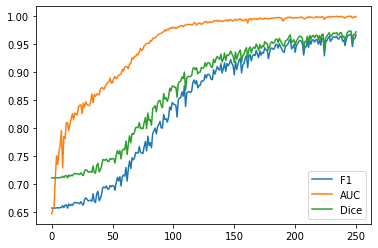

In [3]:
# save a figure with the three lines from the evaluation
plt.plot(f1_scores, label="F1")
plt.plot(aucs, label="AUC")
plt.plot(dices, label="Dice")
plt.legend(loc="lower right")
plt.savefig(pjoin(project_root_dir, "statistics.png"))
plt.show()

### 1.9 Visualize results(0.5 points)
For any 10 images in the dataset, show the images along the with their segmentation mask.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


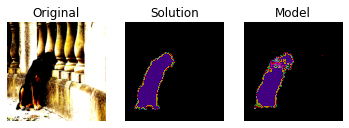

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


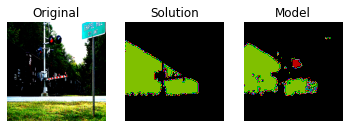

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


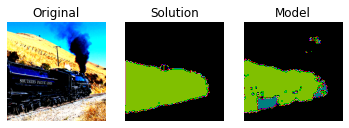

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


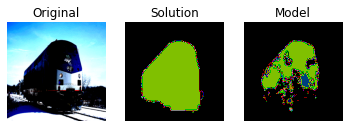

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


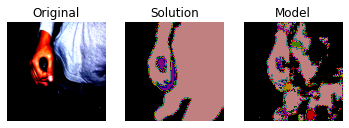

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


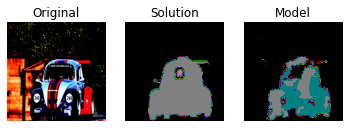

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


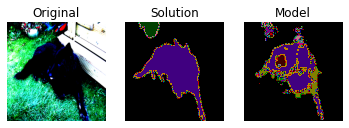

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


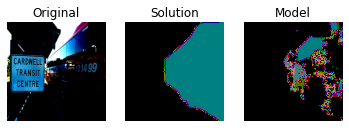

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


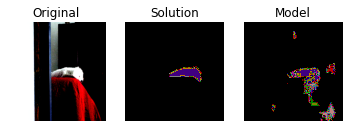

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


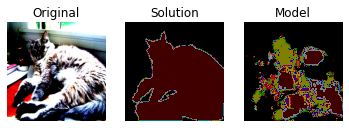

In [29]:
from matplotlib import colors

model = Segnet(weights=pjoin(weights_path, 'network_epoch249.pth')).to(device)

torch.manual_seed(6467)
valloader = data.DataLoader(dst, batch_size=1, shuffle=True)
valloader = iter(valloader)

cmap = colors.ListedColormap(dst.get_pascal_labels() / 255)
bounds = list(range(22))
norm = colors.BoundaryNorm(bounds, cmap.N)

for _ in range(10):
    image, solution = next(valloader)

    fig = plt.figure()
    im1 = fig.add_subplot(131)
    im1.imshow(image[0].transpose(0, 2).transpose(0, 1).numpy())
    im1.title.set_text("Original")
    im1.axis("off")
    
    im2 = fig.add_subplot(132)
    im2.imshow(solution[0].numpy().astype('uint8'), cmap=cmap, norm=norm)
    im2.title.set_text("Solution")
    im2.axis("off")
    
    im3 = fig.add_subplot(133)
    with torch.no_grad():
        model_output = model.classify(image.to(device)).squeeze().cpu()
    im3.imshow(model_output.numpy().astype('uint8'), cmap=cmap, norm=norm)
    im3.title.set_text("Model")
    im3.axis("off")
    
    plt.show()
